In [1]:
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

import matplotlib.pyplot as plt

In [2]:
df_baby = pd.read_json('/content/drive/MyDrive/COLAB/NLP/Practica/datasets/reviews_Baby_5.json', lines=True )
df_electronic = pd.read_json('/content/drive/MyDrive/COLAB/NLP/Practica/datasets/reviews_Electronics_5.json', lines=True )
df_healthAnnPersonalCare = pd.read_json('/content/drive/MyDrive/COLAB/NLP/Practica/datasets/reviews_Health_and_Personal_Care_5.json', lines=True )
df_sportsAndOutdoors = pd.read_json('/content/drive/MyDrive/COLAB/NLP/Practica/datasets/reviews_Sports_and_Outdoors_5.json', lines=True )

In [3]:
dfAll = [df_baby, df_electronic, df_healthAnnPersonalCare, df_sportsAndOutdoors]
df = pd.concat(dfAll)

In [4]:
df = df.iloc[:200000,]
df.head(5)

reviewerID        asin  ... unixReviewTime   reviewTime
0  A1HK2FQW6KXQB2  097293751X  ...     1373932800  07 16, 2013
1  A19K65VY14D13R  097293751X  ...     1372464000  06 29, 2013
2  A2LL1TGG90977E  097293751X  ...     1395187200  03 19, 2014
3   A5G19RYX8599E  097293751X  ...     1376697600  08 17, 2013
4   A2496A4EWMLQ7  097293751X  ...     1396310400   04 1, 2014

[5 rows x 9 columns]

In [5]:
df = df[['reviewText', 'overall']]
df.dropna(inplace=True)

In [6]:
df.head()

reviewText  overall
0  Perfect for new parents. We were able to keep ...        5
1  This book is such a life saver.  It has been s...        5
2  Helps me know exactly how my babies day has go...        5
3  I bought this a few times for my older son and...        5
4  I wanted an alternative to printing out daily ...        4

In [7]:
# Tenemos puntuaciones de 0 a 5 estrellas
# Decido que 1,2,3 sean reviews negativas y 4,5 positivos.

def label_sentiment(row):
    if int(row['overall']) <= 3:
        return 'neg'
    else:
        return 'pos'

In [8]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)

In [9]:
df.head()

reviewText  overall sentiment_label
0  Perfect for new parents. We were able to keep ...        5             pos
1  This book is such a life saver.  It has been s...        5             pos
2  Helps me know exactly how my babies day has go...        5             pos
3  I bought this a few times for my older son and...        5             pos
4  I wanted an alternative to printing out daily ...        4             pos

In [10]:
# Train y Test
X_train, X_test, y_train, y_test = train_test_split(
    df['reviewText'],
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [11]:
X_train.iloc[:10]

21743     I love the Waldorf-type dolls and own more tha...
124554    This is a great carrier if you have back probl...
10351     So much bigger than we expected! Perfect for a...
135164    This item is not made for an early teether of ...
49969     My son loves using this.  It works well and is...
47120     The 2-Phase Expression technology is amazing a...
4249      I like Gerber products. My son uses Gerber bot...
59266     My baby loves this little dog.  She likes bein...
32546     My daughter has loved this jumparoo! She's use...
74977     We have been using this product since, my now ...
Name: reviewText, dtype: object

In [12]:
y_train.iloc[:10]

21743     neg
124554    pos
10351     pos
135164    neg
49969     pos
47120     pos
4249      pos
59266     pos
32546     pos
74977     pos
Name: sentiment_label, dtype: object

In [13]:
# Extracción de features
# convierto a minusculas
# Elimino acentos y simbolos especiales
# Trabajare con 3500 palabras máximas

cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=3500,
    strip_accents='unicode',
    stop_words = 'english',
    ngram_range=(2, 4)
)
cv.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=3500,
                min_df=5, ngram_range=(2, 4), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents='unicode',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [14]:
print(list(cv.vocabulary_.items())[:20])

[('just don', 1509), ('don want', 898), ('baby able', 128), ('able use', 74), ('period time', 2251), ('time great', 3019), ('make sure', 1936), ('safe baby', 2600), ('mo old', 1988), ('day long', 687), ('living room', 1777), ('baby needs', 206), ('lots room', 1845), ('time baby', 3006), ('maybe just', 1963), ('son loves', 2809), ('easy use', 980), ('like said', 1709), ('price great', 2344), ('great product', 1297)]


In [15]:
# TF-IDF scores del training set y test set
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

In [16]:
# Palabras con el TF-IDF en alguna review
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 109170
Sentiment: pos
Review: This is a great bag. Along with the super cute design, it has two pockets to separate items. Well made!  Its a good size and can fit right into my purse or my diaper bag. I've used planet wise bags before and not had any problems with leakage or any tearing at seams or zippers so I'm sure this will be no different!


In [17]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 109170:
                     tfidf
purse diaper bag  0.343035
purse diaper      0.341632
great bag         0.337369
planet wise       0.331825
fit right         0.325024
size fit          0.323651
cute design       0.319987
good size         0.269051
super cute        0.262193
ve used           0.220852

Top 10 words with lowest TF_IDF in the review 109170:
                 tfidf
purse diaper  0.341632
great bag     0.337369
planet wise   0.331825
fit right     0.325024
size fit      0.323651
cute design   0.319987
good size     0.269051
super cute    0.262193
ve used       0.220852
diaper bag    0.197479


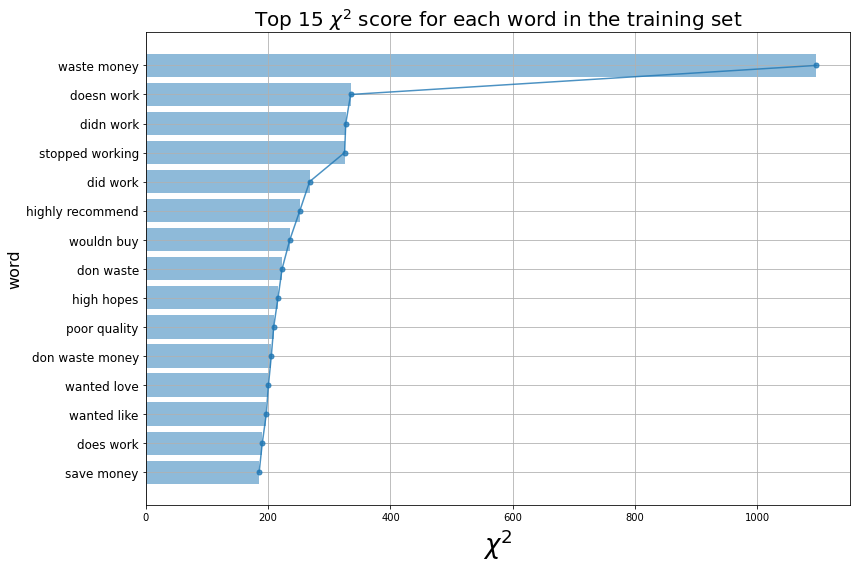

In [18]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

In [19]:
# Entrenamiento
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.79072
Accuracy for C=0.05: 0.80362
Accuracy for C=0.25: 0.82196
Accuracy for C=0.5: 0.82452
Accuracy for C=1: 0.82638
Accuracy for C=10: 0.8266


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy for C=100: 0.82652


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy for C=1000: 0.82644


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy for C=10000: 0.82646


In [20]:
print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

Accuracy for C=10000: 0.82646


In [21]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[ 3627  6875]
 [ 1802 37696]]

Classification report:
              precision    recall  f1-score   support

         neg       0.67      0.35      0.46     10502
         pos       0.85      0.95      0.90     39498

    accuracy                           0.83     50000
   macro avg       0.76      0.65      0.68     50000
weighted avg       0.81      0.83      0.80     50000

Accuracy score:0.82646


In [22]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[ 3627  6875]
 [ 1802 37696]]

Classification report:
              precision    recall  f1-score   support

         neg       0.67      0.35      0.46     10502
         pos       0.85      0.95      0.90     39498

    accuracy                           0.83     50000
   macro avg       0.76      0.65      0.68     50000
weighted avg       0.81      0.83      0.80     50000

Accuracy score:0.82646


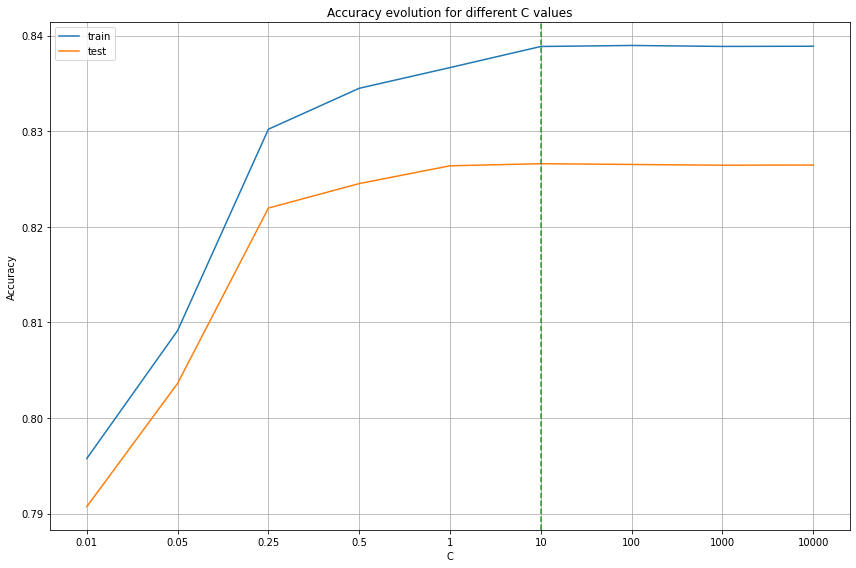

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

In [24]:
# Predict
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index]['sentiment_label']))
    r = df.iloc[review_index]['reviewText']
    print('Prediction: {}'.format(lr.predict(cv.transform([r]))))

In [25]:
for i in random.sample(range(0, len(df)), 20):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 181440
Actual sentiment: pos
Prediction: ['pos']

Review no. 36746
Actual sentiment: pos
Prediction: ['pos']

Review no. 183833
Actual sentiment: pos
Prediction: ['pos']

Review no. 71662
Actual sentiment: pos
Prediction: ['pos']

Review no. 150109
Actual sentiment: pos
Prediction: ['pos']

Review no. 15690
Actual sentiment: pos
Prediction: ['pos']

Review no. 146024
Actual sentiment: pos
Prediction: ['pos']

Review no. 35936
Actual sentiment: neg
Prediction: ['neg']

Review no. 170239
Actual sentiment: pos
Prediction: ['pos']

Review no. 171133
Actual sentiment: pos
Prediction: ['pos']

Review no. 170480
Actual sentiment: pos
Prediction: ['pos']

Review no. 27222
Actual sentiment: pos
Prediction: ['pos']

Review no. 31296
Actual sentiment: pos
Prediction: ['pos']

Review no. 10338
Actual sentiment: neg
Prediction: ['pos']

Review no. 183083
Actual sentiment: pos
Prediction: ['pos']

Review no. 20981
Actual sentiment: pos
Prediction: ['pos']

Review no. 153938
Actual sentim